# Catalog Tools: How To
<div class="alert alert-block alert-info">

#### In this notebook we will show how to:

<ol>
    <li>Download catalogs</li>
    <li>Plot the seismicity</li>
    <li>Generate synthetic earthquakes</li>
    <li>Bin magnitudes</li>
    <li>Calculate b-values</li> 
</ol>

</div>

## 0. Import general packages

In [1]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## 1. Download catalog
<div class="alert alert-block alert-warning">
<font color=#208de2>     

We currently have capability to do a customized download for (includes converting to the catalog-tools standard format):
<ol>
    <li>SCEDC (southern California)</li>
    <li>SED (Switzerland)</li>
</ol>

Otherwise, we have a general download function, where the client name has to be specified (e.g. EMSC). Depending on the source, the catalog has to be further converted in order to be able to use the plotting functions.

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The 'c-t standard format' is a dataframe with the following collumns (additional collumns are not a problem):
    
|column header |type | importance|
|:-|:-|:-|
|latitude |float |required|
|longitude |float |required|
|depth| float| required|
|mag_type| string| optional|
|magnitude| float| required| 
|time| pandas timestamp| required|
|event_type| string| optional|
</font>
</div>

### 1.1. SED Catalog

In [2]:
from catalog_tools import download_catalog_sed

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [3]:
start_time = pd.to_datetime('2020/01/01')
end_time = pd.to_datetime('2022/01/01')

#end_time = dt.datetime.now()

min_magnitude = 2

df_sed = download_catalog_sed(
        start_time=start_time,
        end_time=end_time,
        min_magnitude=min_magnitude,
)

http://arclink.ethz.ch/fdsnws/event/1/query?starttime=2020-01-01T00:00:00&endtime=2022-01-01T00:00:00&minmagnitude=2.0&format=text


<font color=#208de2> The output is a dataframe:</font>

In [4]:
df_sed.tail()

,#EventID,time,latitude,longitude,depth,Author,Catalog,Contributor,ContributorID,mag_type,magnitude,MagAuthor,EventLocationName,event_type
4,smi:ch.ethz.sed/sc20a/Event/2021yzugwx,2021-12-20 23:36:00.020508,45.937659,10.887420,10.5,tdiehl@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2021yzugwx,MLhc,2.1,tdiehl@sc20ag,Lago di Garda I,earthquake
3,smi:ch.ethz.sed/sc20a/Event/2021zamwcn,2021-12-21 08:56:46.307560,47.075317,6.613590,5.1,tdiehl@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2021zamwcn,MLhc,2.9,tdiehl@sc20ag,Le Locle NE,earthquake
2,smi:ch.ethz.sed/sc20a/Event/2021zhdzar,2021-12-24 23:59:56.706839,47.373494,6.918607,4.4,tdiehl@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2021zhdzar,MLhc,4.1,tdiehl@sc20ag,Porrentruy JU,earthquake
1,smi:ch.ethz.sed/sc20a/Event/2021zihlix,2021-12-25 14:49:40.125942,47.371755,6.917057,3.4,tdiehl@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2021zihlix,MLhc,3.5,tdiehl@sc20ag,Porrentruy JU,earthquake
0,smi:ch.ethz.sed/sc20a/Event/2021zqxyri,2021-12-30 07:43:14.681975,46.051445,7.388025,1.2,tdiehl@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2021zqxyri,MLhc,2.5,tdiehl@sc20ag,Arolla VS,earthquake


### 1.2. SCEDC Catalog

In [5]:
from catalog_tools import download_catalog_scedc

In [6]:
start_time = pd.to_datetime('2020/01/01')
end_time = dt.datetime.now()

min_magnitude = 5

df_scedc = download_catalog_scedc(
        start_time=start_time,
        end_time=end_time,
        min_magnitude=min_magnitude,
)

https://service.scedc.caltech.edu/fdsnws/event/1/query?starttime=2020-01-01T00:00:00&endtime=2023-06-21T14:22:40&minmagnitude=5.0&format=text


### 1.3. General Catalog download function

In [7]:
from catalog_tools import download_catalog

In [8]:
start_time = pd.to_datetime('2023/01/01')
end_time = dt.datetime.now()

min_magnitude = 5

df = download_catalog(client_name='EMSC',
        start_time=start_time,
        end_time=end_time,
        min_magnitude=min_magnitude,
)

## 2. Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We plot the seismicity in time and space, and the cumulative frequency-magnitude distribution. There are three kind of plotting families:

<ol>
<li>Plot in space</li>
<li>Plot magnitude distribution</li>
<li>Plot in time</li> 
</ol>

</font>
</div>

### 2.1. Plot in space

In [9]:
from catalog_tools import plot_in_space

<font color=#208de2>
It is possible to choose the resolutions 10, 50 and 110. Optionally you can choose the color scheme and the country of which you want to see the borders. For large areas/countries, the plotting can take some time (to be fixed in the future).
</font>


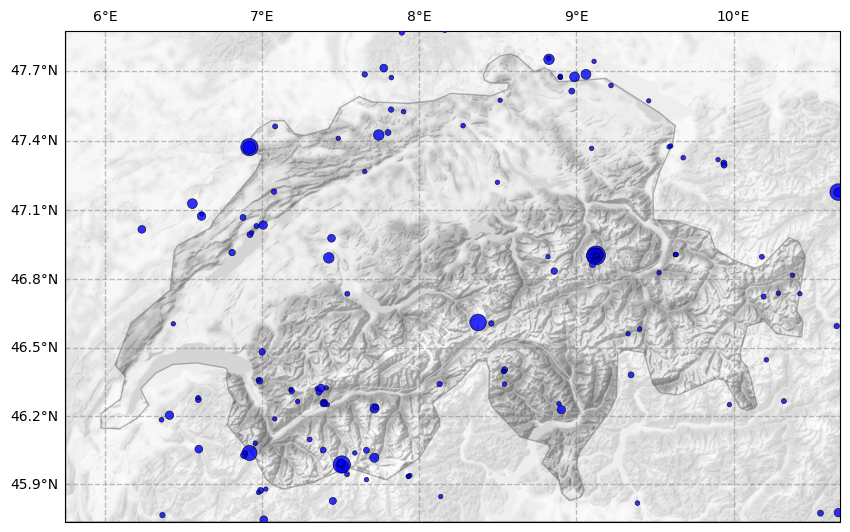

In [ ]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df_sed, resolution='50m', include_map=True, country='Switzerland', colors='Greys_r')

<font color=#208de2>
You can also choose the interpolation power and the size of the smallest and largest dot. 
</font>


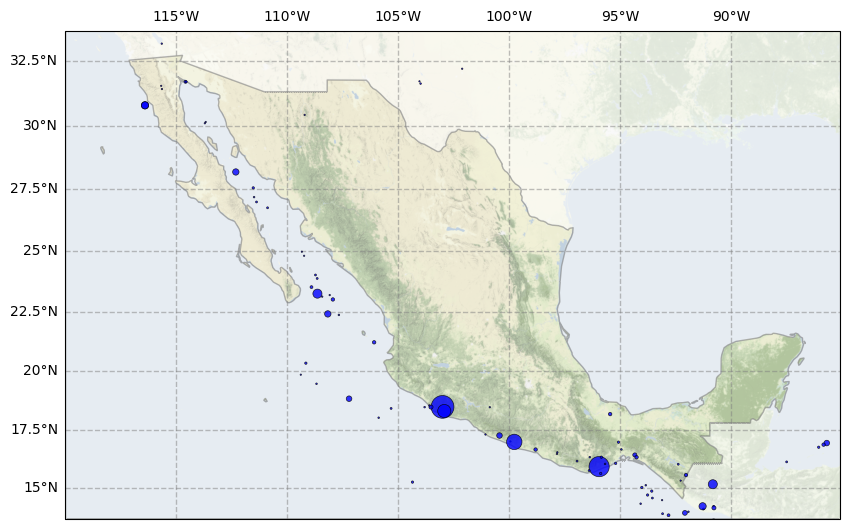

In [ ]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df_scedc, resolution='50m', include_map=True, country='Mexico', dot_smallest=1, dot_largest=500,
                   dot_interpolation_power=3)

<font color=#208de2>
The default is that the map is not included. For now, this is the best way to plot global seismicity.
</font>

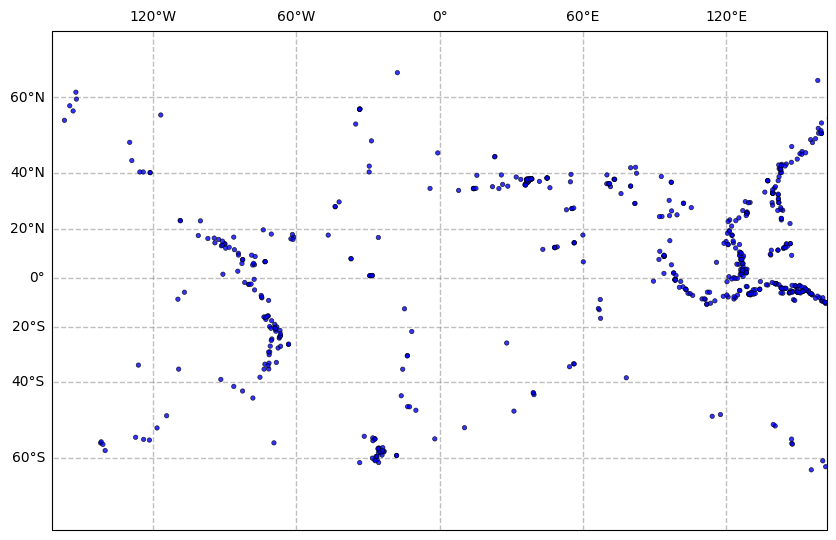

In [12]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, dot_smallest=0.1, dot_largest=10, dot_interpolation_power=0)

### 2.2. Plot magnitude distributions

In [13]:
from catalog_tools import plot_cum_fmd, plot_fmd

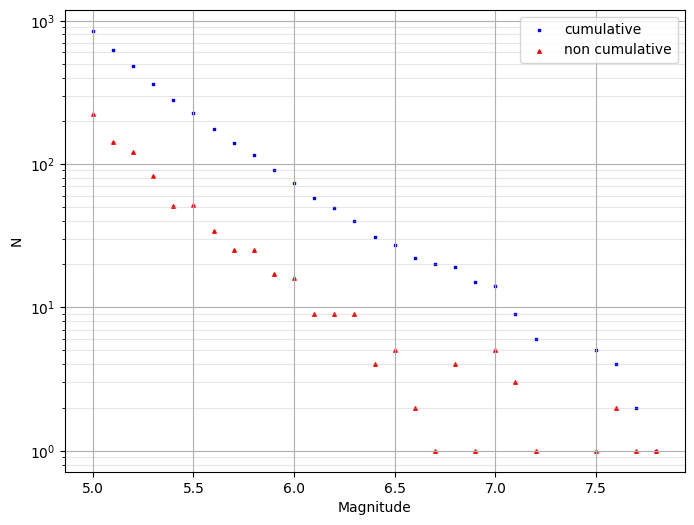

In [14]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], ax=ax, color='blue')
plot_fmd(df['magnitude'], ax=ax, color='red', size=6, grid=True)

ax.legend(['cumulative', 'non cumulative'])

### 2.3. Plot in time

In [15]:
from catalog_tools import plot_cum_count, plot_mags_in_time

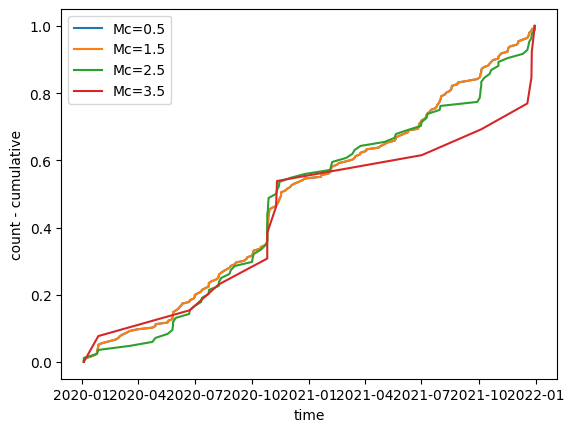

In [16]:
ax = plot_cum_count(df_sed, mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

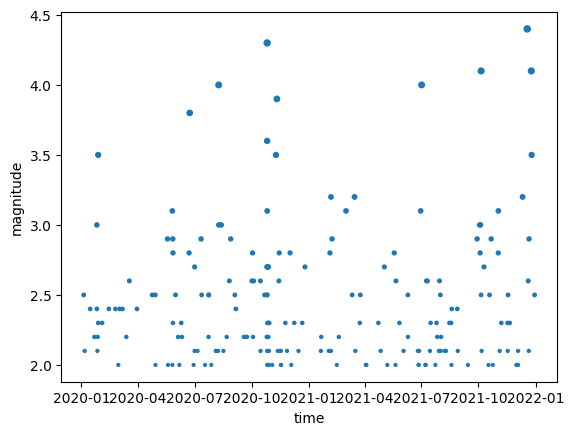

In [17]:
ax = plot_mags_in_time(df_sed)

## 3. Generate and bin synthetic earthquakes

<div class="alert alert-block alert-warning">
<font color=#208de2>     
First we need to define the number of earthquakes, the b-value and the completeness magnitude. If binnning is applied, it is important to generate the magnitudes half a bin smaller than the smallest magnitude, otherwise the first bin will contain only half the events. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value.
</font>
</div>

In [18]:
from catalog_tools import simulate_magnitudes, bin_to_precision

In [19]:
n = 200
b_value = 1
beta = b_value*np.log(10)
delta_m = 0.1
mc = 3
mc_generation = mc - delta_m / 2

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [20]:
mags = simulate_magnitudes(n,beta,mc_generation)

<font color=#208de2> In order to bin the magnitudes, we just need to define the step-size: </font>

In [21]:
mags_binned = bin_to_precision(mags, delta_m)

## 4. Calculate b-values

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We estimate the b-value from the binned sample. It is important to pass on the information of which binning (if any) is applied. Also, be cautious that beta is (as above) a factor of np.log(10) different to the b-value.
</font>
</div>

In [22]:
from catalog_tools import estimate_beta_elst, estimate_beta_utsu, estimate_beta_tinti, estimate_beta_laplace

# Other b-value estimation methods:
# from catalog_tools import estimate_beta_elst, estimate_beta_tinti, estimate_beta_laplace

In [23]:
beta_estimate = estimate_beta_tinti(mags_binned, mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_utsu(mags_binned,mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_elst(mags_binned, delta_m=delta_m)
# beta_estimate = estimate_beta_laplace(mags_binned, delta_m=delta_m)

<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that the data are offset by half the binning size so that the cumulative number is shown correctly. </font>

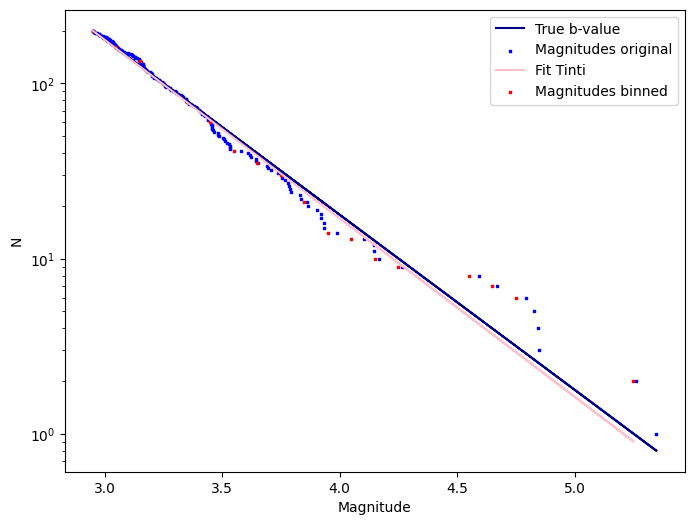

In [24]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(mags, ax=ax, b_value=b_value, mc=mc - delta_m/2, color=['blue', 'darkblue'])
plot_cum_fmd(mags_binned,ax=ax, b_value=beta_estimate/np.log(10), delta_m=delta_m, color=['red', 'pink'])

ax.legend(['True b-value', 'Magnitudes original', 'Fit Tinti', 'Magnitudes binned'])